# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 2: benchmarking on coaxial vision dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from vision_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns


### Utils functions

In [32]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'class_name_v2','train_visual')
os.makedirs(IMAGE_PATH, exist_ok=True)

model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'class_name_v2', 'visual_model')

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [28]:
classes = ('Defect-free', 'Defective', 'Laser-off')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")


SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 10

### Use GPU if possible

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.033 seconds (sampling freqeuncy 30 Hz.)

In [6]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name'])

# Fill NaN values in 'class_name' with 'Unlabeled'
# df_multimodal['class_name'] = df_multimodal['class_name'].astype(str)
# df_multimodal['class_name'].fillna('Unlabeled', inplace=True)
df_multimodal

,sample index,Time_Stamps,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,rms_energy,amplitude_envelope_mean,...,center_y,contour_area,contour_length,X,Y,Z,Vx,Vy,Vz,Speed
0,1,0.00,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,0.009018,0.003034,...,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,2,0.04,sample_21_2.wav,sample_21_2.jpg,Defect-free,Defect-free,1.0,21,0.019286,0.012109,...,239.000000,305442.0,2234.000000,0.000,-0.000,0.001,-0.074,-0.074,0.000,0.105
2,3,0.08,sample_21_3.wav,sample_21_3.jpg,Defect-free,Defect-free,1.0,21,0.019593,0.015114,...,239.000000,305442.0,2234.000000,-0.010,0.015,-0.007,-0.051,0.026,-0.051,0.077
3,4,0.12,sample_21_4.wav,sample_21_4.jpg,Defect-free,Defect-free,1.0,21,0.030937,0.021501,...,230.264496,291865.5,2279.781744,-0.007,0.016,0.010,0.173,-0.222,2.520,2.536
4,5,0.16,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,0.038329,0.029851,...,229.109962,281970.0,2407.847760,-0.111,0.123,-0.057,-1.864,1.662,-2.468,3.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48461,10982,439.24,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,Laser-off,NaN,26,0.011000,0.009066,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48462,10983,439.28,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,Laser-off,NaN,26,0.008347,0.006188,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48463,10984,439.32,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,Laser-off,NaN,26,0.011081,0.007763,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48464,10985,439.36,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,Laser-off,NaN,26,0.011044,0.007960,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080


In [7]:
def get_sample_directories_from_df(df, Dataset_path):
    # Extract unique sample numbers from the DataFrame
    unique_sample_numbers = df['Sample number'].unique()
    
    # Generate the full paths for image and audio directories
    image_directories = [os.path.join(Dataset_path, str(sample_number), 'images') for sample_number in unique_sample_numbers]
    audio_directories = [os.path.join(Dataset_path, str(sample_number), 'raw_audio') for sample_number in unique_sample_numbers]
    
    return image_directories, audio_directories

samples = [21, 22, 23, 24, 26, 32]
image_directories, audio_directories = get_sample_directories_from_df(df_multimodal, Dataset_path)

In [8]:
image_directories

['/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/21/images',
 '/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/22/images',
 '/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/23/images',
 '/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/24/images',
 '/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/26/images']

In [9]:
# Get the labels and count the number of samples for each class
labels = df_multimodal['class_name_v2'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 8993  5806 18147]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **55%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [10]:
### Get the percentage distribution of each category
round(df_multimodal.groupby('class_name_v2')["class_name_v2"].count()/df_multimodal.shape[0]*100, 1)

class_name_v2
Defect-free    27.3
Defective      17.6
Laser-off      55.1
Name: class_name_v2, dtype: float64

Saving figure dataset_distribution.png


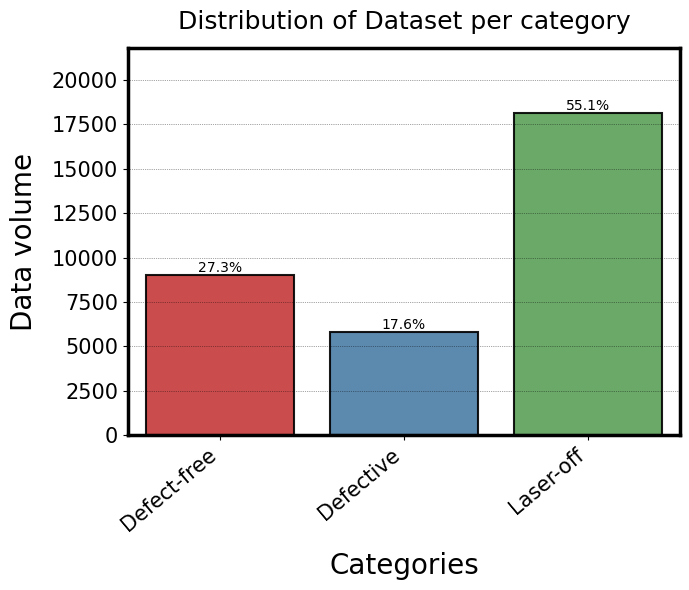

In [11]:
plot_data_distribution(df_multimodal, 'class_name_v2', 
                       'Distribution of Dataset per category', 'dataset_distribution')

## Preparing Dataset and DataLoader

Mean: 76.93087324120341

Standard Deviation: 71.49791275013504

In [12]:
#------ transformation------
train_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.RandomHorizontalFlip(),  # data augmentation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

val_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

In [13]:
#------ data loader------
# create the dataset for all samples
visiondataset = LDEDVisionDataset(df_multimodal,
                                  image_directories,
                                  samples,
                                  train_transforms,
                                  device)
print ("length of the total dataset:" + str(len(visiondataset)))

length of the total dataset:32946


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set (or only train/val set, depending on the data volume)
- Train and Val are used for hyperparameter tuning
- Train set will go through data augmentation

In [14]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(df_multimodal, labels))

# split the data into train and test sets
train_annotations = df_multimodal.iloc[train_indices, :]
test_annotations = df_multimodal.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = LDEDVisionDataset(train_annotations,
                                  image_directories,
                                  samples,
                                  train_transforms,
                                  device)

val_dataset = LDEDVisionDataset(test_annotations,
                                image_directories,
                                samples,
                                val_transforms,
                                device)

In [15]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# # split the indices of annotations into train, validation and test sets
# train_indices, test_val_indices = next(sss.split(annotations_df, labels))

# # Use another StratifiedShuffleSplit to split the test_val_indices into test and validation sets
# val_size = 0.5 # set the validation size
# sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=0)
# val_indices, test_indices = next(sss2.split(annotations_df.iloc[test_val_indices], labels[test_val_indices]))

# # split the data into train, validation, and test sets
# train_annotations = annotations_df.iloc[train_indices, :]
# val_annotations = annotations_df.iloc[val_indices, :]
# test_annotations = annotations_df.iloc[test_indices, :]

# # Create the train, validation and test datasets
# train_dataset = LDEDVisionDataset(train_annotations,
#                                   image_path = VISON_DIR,
#                                   image_transformation=train_transforms,
#                                   device=device)

# val_dataset = LDEDVisionDataset(val_annotations,
#                                 image_path=VISON_DIR,
#                                 image_transformation=val_transforms,
#                                 device=device)

# test_dataset = LDEDVisionDataset(test_annotations,
#                                  image_path=VISON_DIR,
#                                  image_transformation=val_transforms,
#                                  device=device)

### Create DataLoader using the dataset

In [16]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:26356
length of the val dataset:6590


## Training the model

In [17]:
resume = False
start_epoch = 0
best_acc = 0

In [18]:
# -----Model---------------
print('==> Building model..')
net = VGG('VGG19')
# net = LeNet() 
# net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
# net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
#     train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
#     test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
#     scheduler.step()

# model, optimizer, _ = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)
model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, 
                                                                                               val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                                                                                                                                         | 0/206 [00:24<?, ?it/s, loss=0.0565, accuracy=98.1]


13:55:36 --- Epoch: 0	Train loss: 0.1381	Valid loss: 0.0018	Train accuracy: 94.95	Valid accuracy: 98.10

Epoch: 1


Epoch 1:   0%|                                                                                                                                         | 0/206 [00:17<?, ?it/s, loss=0.0469, accuracy=98.5]


13:57:05 --- Epoch: 1	Train loss: 0.0907	Valid loss: 0.0015	Train accuracy: 96.87	Valid accuracy: 98.54

Epoch: 2


Epoch 2:   0%|                                                                                                                                         | 0/206 [00:15<?, ?it/s, loss=0.0528, accuracy=98.1]


13:58:39 --- Epoch: 2	Train loss: 0.0780	Valid loss: 0.0017	Train accuracy: 97.44	Valid accuracy: 98.07

Epoch: 3


Epoch 3:   0%|                                                                                                                                         | 0/206 [00:13<?, ?it/s, loss=0.0463, accuracy=98.5]


14:00:14 --- Epoch: 3	Train loss: 0.0736	Valid loss: 0.0014	Train accuracy: 97.56	Valid accuracy: 98.48

Epoch: 4


Epoch 4:   0%|                                                                                                                                         | 0/206 [00:18<?, ?it/s, loss=0.0459, accuracy=98.4]


14:01:49 --- Epoch: 4	Train loss: 0.0725	Valid loss: 0.0014	Train accuracy: 97.73	Valid accuracy: 98.42

Epoch: 5


Epoch 5:   0%|                                                                                                                                         | 0/206 [00:26<?, ?it/s, loss=0.0581, accuracy=97.9]


14:03:28 --- Epoch: 5	Train loss: 0.0674	Valid loss: 0.0018	Train accuracy: 97.83	Valid accuracy: 97.94

Epoch: 6


Epoch 6:   0%|                                                                                                                                         | 0/206 [00:25<?, ?it/s, loss=0.0466, accuracy=98.8]


14:05:26 --- Epoch: 6	Train loss: 0.0657	Valid loss: 0.0015	Train accuracy: 97.86	Valid accuracy: 98.83

Epoch: 7


Epoch 7:   0%|                                                                                                                                         | 0/206 [00:23<?, ?it/s, loss=0.0429, accuracy=98.7]


14:07:35 --- Epoch: 7	Train loss: 0.0667	Valid loss: 0.0013	Train accuracy: 97.80	Valid accuracy: 98.74

Epoch: 8


Epoch 8:   0%|                                                                                                                                         | 0/206 [00:14<?, ?it/s, loss=0.0606, accuracy=97.5]


14:08:54 --- Epoch: 8	Train loss: 0.0602	Valid loss: 0.0019	Train accuracy: 98.13	Valid accuracy: 97.47

Epoch: 9


Epoch 9:   0%|                                                                                                                                         | 0/206 [00:20<?, ?it/s, loss=0.0561, accuracy=97.6]

14:10:09 --- Epoch: 9	Train loss: 0.0603	Valid loss: 0.0018	Train accuracy: 97.97	Valid accuracy: 97.62


In [19]:
valid_accuracy

[98.103186646434,
 98.5432473444613,
 98.07283763277694,
 98.48254931714719,
 98.42185128983309,
 97.93626707132019,
 98.83156297420334,
 98.74051593323217,
 97.4658573596358,
 97.6176024279211]

Saving figure train_lost_curve_visual


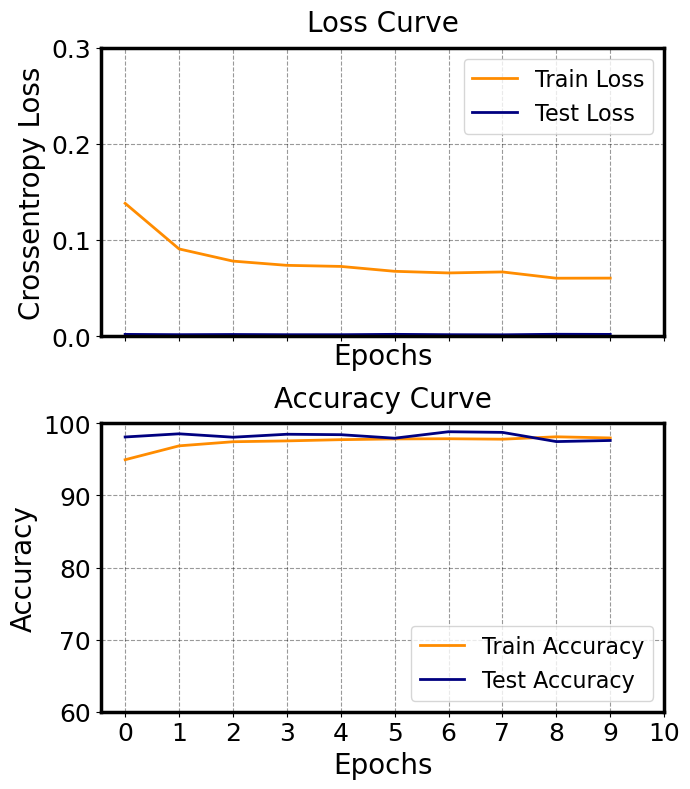

In [20]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 10, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=0.30, yacc_limit1=60, yacc_limit2=100)

save_fig ("train_lost_curve_visual")

In [21]:
get_accuracy(model, val_dataloader, device)

0.9761760242792109

Test Accuracy (cross-validation) for visual_VGG19 = 0.97618 ± 0.00274
micro-averaging AUC for visual_VGG19 = 0.99854 ± 0.00000
Saving figure ROC_curve (vision-based)


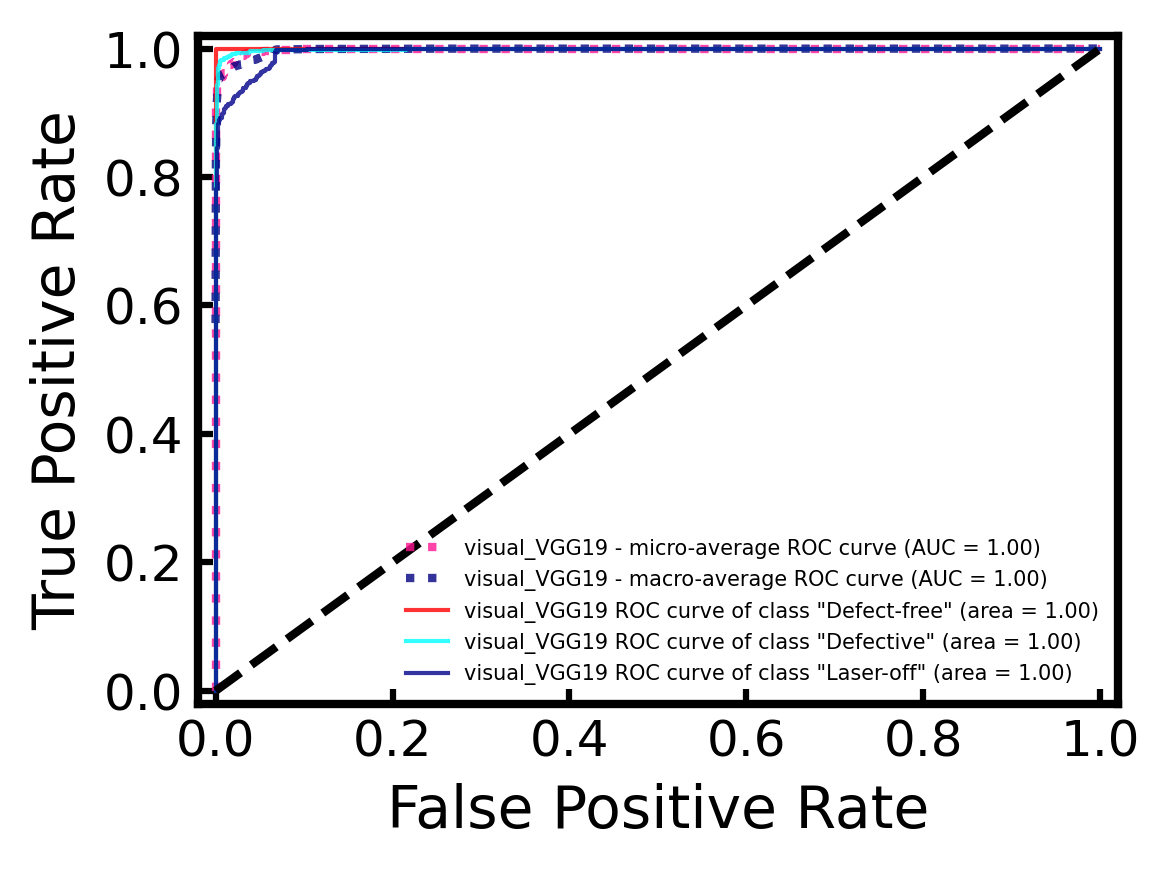

In [79]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "visual_VGG19", 
                                                                            signal_type = "denoised", seed=0)

save_fig ("ROC_curve (vision-based)")

In [80]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std

(0.976176024279211, 0.002739828541011801, 0.998541819697385, 0.0)

In [31]:
yt, yp = class_report(model, val_dataloader, device, classes)

              precision    recall  f1-score   support

 Defect-free     0.9989    0.9994    0.9992      3630
   Defective     0.9964    0.9172    0.9551      1799
   Laser-off     0.8871    0.9948    0.9379      1161

    accuracy                         0.9762      6590
   macro avg     0.9608    0.9705    0.9641      6590
weighted avg     0.9785    0.9762    0.9764      6590



In [26]:
def conf_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    print(cm)
    plot_confusion_matrix(cm_pct, classes)

[[1650  145    4]
 [   6 1155    0]
 [   0    2 3628]]
Saving figure confusion_matrix(vision_based)


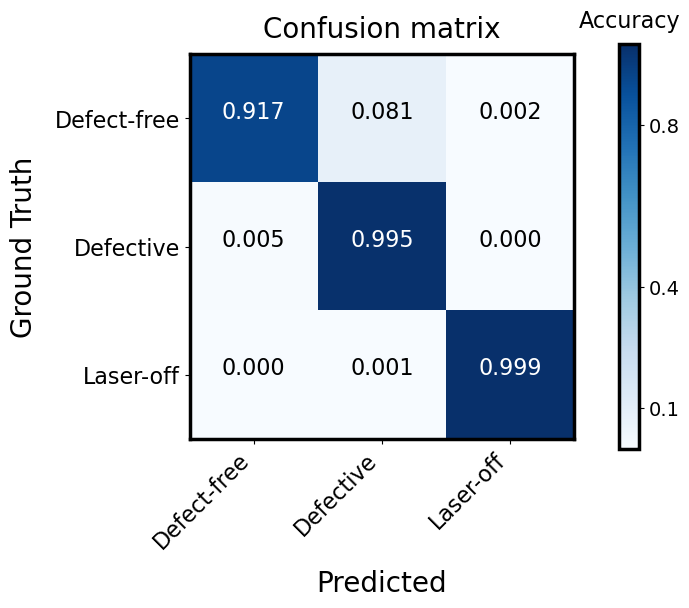

In [29]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(vision_based)")

### Save the trained model into the folder

In [34]:
# Save the model's state_dict
torch.save(model.state_dict(), os.path.join(model_path, 'trained_visual_VGG19.pth'))

# Load the trained model to test

In [37]:
# Initialize your model
model = nn.DataParallel(VGG('VGG19'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the state dictionary
model.load_state_dict(torch.load(os.path.join(model_path, 'trained_visual_VGG19.pth')))


model.eval()  # Set the model to evaluation mode

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

#### Random testing

Predicted label index: 1
Predicted class name: Defect-free


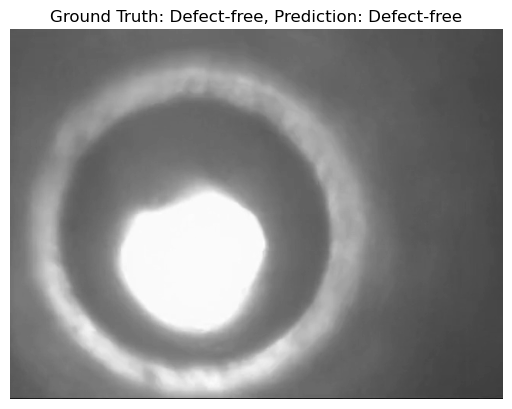

In [78]:
import PIL.Image

# Define the image transformation
transform = transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

# Load and preprocess the image
sample_number = 21
index = 1203
img_path = os.path.join(Dataset_path, f"{sample_number}/images/sample_{sample_number}_{index}.jpg")
input_image = PIL.Image.open(img_path).convert('L')  
input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)

# Make the prediction
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get the label, we can use argmax to get the index of the maximum score
_, predicted_label_index = torch.max(output, 1)

print(f"Predicted label index: {predicted_label_index.item()}")


# (1) Map the predicted index to the actual class name
index_to_class = {
    0: 'Laser-off',
    1: 'Defect-free',
    2: 'Defective'
}

predicted_class_name = index_to_class[predicted_label_index.item()]
print(f"Predicted class name: {predicted_class_name}")

# (2) Display the image and print the ground truth label
try:
    ground_truth_label = df_multimodal.loc[
        (df_multimodal['Sample number'] == sample_number) & 
        (df_multimodal['image_file_name'] == f"sample_{sample_number}_{index}.jpg"), 
        'class_name_v2'
    ].iloc[0]
except IndexError:
    ground_truth_label = "NaN"


# Display the image
plt.imshow(input_image, cmap='gray')
plt.title(f"Ground Truth: {ground_truth_label}, Prediction: {predicted_class_name}")
plt.axis('off')
plt.show()